In [0]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Reshape, Activation, Input
from keras.models import Model
from keras.layers.merge import Dot
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import skipgrams
import numpy as np
from google.colab import files
from keras.utils.data_utils import get_file
from keras.utils import np_utils
import gensim

In [2]:
# get Alice’s Adventures in Wonderland
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
all_lines = open(path).readlines()

180224/173595 [===============================] - 0s 1us/step


In [0]:
# get rid of to short senntences
corpus = [line for line in all_lines if line.count(" ") > 2]

In [0]:
# tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [0]:
# inputs
word_input = Input(shape=(1, ), dtype='int32')
context_input = Input(shape=(1, ), dtype='int32')

# embeddings
embedding_input_dim,embedding_output_dim  = len(tokenizer.word_index) + 1, 128
word_embedding = Embedding(embedding_input_dim, embedding_output_dim)(word_input)
context_embedding  = Embedding(embedding_input_dim, embedding_output_dim)(context_input)

# outputs 
merged = Dot(axes=2)([word_embedding, context_embedding])
output = Activation('sigmoid')(Reshape((1,), input_shape=(1, 1))(merged))

#model
skipgram_model = Model(inputs=[word_input, context_input], outputs=output)
skipgram_model.compile(loss='binary_crossentropy', optimizer='adam')

In [11]:
skipgram_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 128)       432384      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       432384      input_10[0][0]                   
____________________________________________________________________________________________

In [0]:
# prepare skipgram pairs 
batches = [] # contains tuples with (data, labels)
for s in tokenizer.texts_to_sequences(corpus):
  data, labels = skipgrams(sequence=s, vocabulary_size=embedding_input_dim, window_size=5, negative_samples=5.)
  if data:
    batches.append(([np.array(x) for x in zip(*data)], np.array(labels, dtype=np.int32)))

In [27]:
# train model 
epochs = 50
losses = []
for epoch in range(1, epochs +1):
  loss = 0
  for batch in batches:
    loss += skipgram_model.train_on_batch(batch[0], batch[1])
  print("Epoch: {} -> loss: {}".format(epoch, loss))
  losses.append(loss)



Epoch: 1 -> loss: 1051.252786397934
Epoch: 2 -> loss: 725.7190504744649
Epoch: 3 -> loss: 673.4713907539845
Epoch: 4 -> loss: 642.5115934982896
Epoch: 5 -> loss: 611.4956189915538
Epoch: 6 -> loss: 580.1725679319352
Epoch: 7 -> loss: 549.3366713151336
Epoch: 8 -> loss: 520.9147751713172
Epoch: 9 -> loss: 494.5997768067755
Epoch: 10 -> loss: 470.931160912849
Epoch: 11 -> loss: 449.4378014472313
Epoch: 12 -> loss: 430.51380771771073
Epoch: 13 -> loss: 413.4957047959324
Epoch: 14 -> loss: 398.60101983323693
Epoch: 15 -> loss: 385.2042554910877
Epoch: 16 -> loss: 373.67725166660966
Epoch: 17 -> loss: 363.362572422222
Epoch: 18 -> loss: 354.5672172345803
Epoch: 19 -> loss: 346.73599690629635
Epoch: 20 -> loss: 340.1408393881866
Epoch: 21 -> loss: 334.24485639607883
Epoch: 22 -> loss: 329.3575976360298
Epoch: 23 -> loss: 324.93457462000515
Epoch: 24 -> loss: 321.33371385571445
Epoch: 25 -> loss: 318.03213782716557
Epoch: 26 -> loss: 315.39670030723573
Epoch: 27 -> loss: 312.8930613883822
Epo

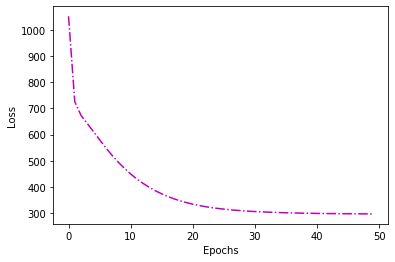

In [66]:
plt.plot(range(0, epochs), losses, '-.', color='m')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [0]:
# save weights as vectors
filename = 'vectors.txt'
f = open(filename ,'w')
f.write('{} {}\n'.format(embedding_input_dim-1, embedding_output_dim))
vectors = skipgram_model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [0]:
files.download(filename) 

In [37]:
# load word 2 vector model
word2vector = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [47]:
# test on few examples 
word2vector.most_similar(positive=['rabbit'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('white', 0.5231320858001709),
 ('returning', 0.4149767756462097),
 ('hush', 0.40843284130096436),
 ('hole', 0.40671664476394653),
 ('sends', 0.38200077414512634),
 ('hedge', 0.3755301237106323),
 ('iv', 0.3692050576210022),
 ('‘here', 0.36456599831581116),
 ('queerest', 0.3590317964553833),
 ('hurrying', 0.35400164127349854)]

In [43]:
word2vector.most_similar(negative=['rabbit'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('effect', 0.28170138597488403),
 ('told', 0.24755747616291046),
 ('cunning', 0.23955807089805603),
 ('created', 0.22925987839698792),
 ('share', 0.21973687410354614),
 ('how', 0.21289119124412537),
 ('network', 0.20988646149635315),
 ('receiving', 0.2098606824874878),
 ('limbs', 0.20609185099601746),
 ('shrimp', 0.20585858821868896)]

In [54]:
word2vector.most_similar(positive=['tree'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('rose', 0.5010441541671753),
 ('yards', 0.4487256407737732),
 ('few', 0.43677932024002075),
 ('red', 0.39474934339523315),
 ('highest', 0.36591383814811707),
 ('entrance', 0.3378671705722809),
 ('branch', 0.32642680406570435),
 ('stood', 0.3039414882659912),
 ('roses', 0.2909202575683594),
 ('somehow', 0.28853291273117065)]

In [58]:
word2vector.most_similar(positive=['good'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('contempt', 0.45568564534187317),
 ('fireplace', 0.43011268973350525),
 ('manners', 0.4190397262573242),
 ('narrow', 0.40215858817100525),
 ('seldom', 0.3777758479118347),
 ('deal', 0.3761124014854431),
 ('naturedly', 0.35397255420684814),
 ('telescope', 0.3528032898902893),
 ('natured', 0.3490862250328064),
 ('escape', 0.34837570786476135)]

In [62]:
word2vector.most_similar(positive=['cat'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cheshire', 0.49838966131210327),
 ('bough', 0.37666547298431396),
 ('‘dinah’s', 0.3751833736896515),
 ('‘allow', 0.3653193414211273),
 ('startled', 0.3507373631000519),
 ('she’s', 0.34446266293525696),
 ('neighbour', 0.3442537784576416),
 ('hope', 0.3291996717453003),
 ('wider', 0.317732572555542),
 ('seeing', 0.31650933623313904)]